# Notes

In [3]:
import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm
import joblib, json

from  sklearn.model_selection  import StratifiedKFold

In [4]:
SR = 32_000
SEED = 666

DATA_ROOT = Path("../input/birdclef-2022")
TRAIN_AUDIO_ROOT = Path("../input/birdclef-2022/train_audio")
TRAIN_AUDIO_IMAGES_SAVE_ROOT = Path("../input/audio_images") # Where to save the mels images
TRAIN_AUDIO_IMAGES_SAVE_ROOT.mkdir(exist_ok=True, parents=True)

In [5]:
def get_audio_info(filepath):
    """Get some properties from  an audio file"""
    with SoundFile(filepath) as f:
        sr = f.samplerate
        frames = f.frames
        duration = float(frames)/sr
    return {"frames": frames, "sr": sr, "duration": duration}

In [6]:
def make_df(n_splits=4, seed=SEED, nrows=None):
    
    df = pd.read_csv(DATA_ROOT/"train_metadata.csv", nrows=nrows)

    LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df["primary_label"].unique()))}
    
#     df = df.iloc[PART_INDEXES[PART_ID]: PART_INDEXES[PART_ID+1]]

    df["filepath"] = [str(TRAIN_AUDIO_ROOT/filename) for primary_label,filename in zip(df.primary_label, df.filename) ]

    pool = joblib.Parallel(4)
    mapper = joblib.delayed(get_audio_info)
    tasks = [mapper(filepath) for filepath in df.filepath]

    df = pd.concat([df, pd.DataFrame(pool(tqdm(tasks)))], axis=1, sort=False)
    
    skf = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
    splits = skf.split(np.arange(len(df)), y=df.primary_label.values)
    df["fold"] = -1

    for fold, (train_set, val_set) in enumerate(splits):
        
        df.loc[df.index[val_set], "fold"] = fold

    return LABEL_IDS, df

In [7]:
LABEL_IDS, df = make_df(nrows=None)

df.to_csv("rich_train_metadata.csv", index=True)
with open("LABEL_IDS.json", "w") as f:
    json.dump(LABEL_IDS, f)

print(df.shape)
df.head()

  0%|          | 0/14852 [00:00<?, ?it/s]

(14852, 18)


/Users/dungvu/miniforge3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename,filepath,frames,sr,duration,fold
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg,../input/birdclef-2022/train_audio/afrsil1/XC1...,355265,32000,11.102031,2
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg,../input/birdclef-2022/train_audio/afrsil1/XC1...,1504653,32000,47.020406,2
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg,../input/birdclef-2022/train_audio/afrsil1/XC1...,1720320,32000,53.760000,2
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg,../input/birdclef-2022/train_audio/afrsil1/XC2...,3375438,32000,105.482438,1
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg,../input/birdclef-2022/train_audio/afrsil1/XC2...,108669,32000,3.395906,3


In [8]:
df["fold"].value_counts()

2    3713
1    3713
3    3713
0    3713
Name: fold, dtype: int64

In [9]:
df["primary_label"].value_counts()

brnowl     500
skylar     500
norcar     500
mallar3    500
houspa     500
          ... 
puaioh       3
layalb       3
akikik       2
crehon       2
maupar       1
Name: primary_label, Length: 152, dtype: int64

In [10]:
# df["duration"].hist(bins=1000)
df['duration'].unique().size

7415

<AxesSubplot:>

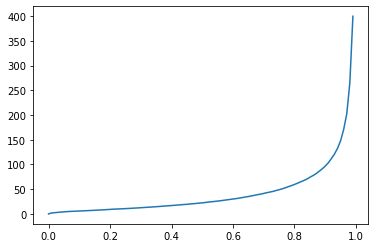

In [11]:
df["duration"].quantile(np.arange(0, 1, 0.01)).plot()

In [12]:
df.to_csv("train_metadata_new.csv")

In [16]:
LABEL_IDS.keys().__len__()

152